In [6]:
import numpy as np
import os
import string
import numpy as np
import pandas as pd
import torch
from torch.utils.data import TensorDataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, FastText
from src.data import get_datasetCML, data_semi_learning

# bản chất auto encoder cũng là dùng mạng nơ ron để mã hóa ảnh thành vector có số chiều nhỏ hơn


## 1. Tiền xử lý dữ liệu:
### Vector hóa dữ liệu: Vì dữ liệu DGA là chuỗi văn bản (tên miền), ta cần biến chúng thành vector số. Một số phương pháp có thể sử dụng:

- One-hot encoding (đơn giản nhưng kích thước lớn)
- Word2Vec / FastText (học biểu diễn từ dữ liệu)
- TF-IDF (phù hợp với dữ liệu văn bản ngắn)
- Character-level CNN / LSTM (sử dụng mạng nơ-ron để trích xuất đặc trưng)

### Augmentation cho dữ liệu DGA:
SwAV hoạt động tốt khi có nhiều phiên bản biến đổi (augmentations) của một mẫu dữ liệu. Với DGA, ta có thể:

- Thay đổi một số ký tự trong tên miền (ví dụ: hoán đổi một số ký tự)
- Thêm hoặc xóa các ký tự ngẫu nhiên
- Dịch chuyển thứ tự ký tự trong một phạm vi nhỏ


In [ ]:
### 1. One-hot Encoding
char2ix = {x: idx + 1 for idx, x in enumerate(string.printable)}
encoded_domains = [[char2ix[y] for y in x if y in char2ix] for x in domains]
maxlen = max(len(domain) for domain in encoded_domains)
padded_domains = pad_sequences(encoded_domains, maxlen)
X_train, X_test, y_train, y_test = train_test_split(padded_domains, labels, test_size=0.10, shuffle=True)
one_hot_trainset = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.Tensor(y_train))
one_hot_testset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.Tensor(y_test))

### 2. TF-IDF
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))  # Dùng n-gram ký tự
X_tfidf = vectorizer.fit_transform(domains).toarray()
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.10, shuffle=True)
tfidf_trainset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.Tensor(y_train))
tfidf_testset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.Tensor(y_test))

### 3. Word2Vec / FastText
sentences = [list(domain) for domain in domains]
word2vec_model = Word2Vec(sentences, vector_size=50, window=5, min_count=1, workers=4)
fasttext_model = FastText(sentences, vector_size=50, window=5, min_count=1, workers=4)

X_w2v = np.array([np.mean([word2vec_model.wv[char] for char in domain if char in word2vec_model.wv], axis=0) for domain in sentences])
X_fasttext = np.array([np.mean([fasttext_model.wv[char] for char in domain if char in fasttext_model.wv], axis=0) for domain in sentences])

X_train, X_test, y_train, y_test = train_test_split(X_w2v, labels, test_size=0.10, shuffle=True)
w2v_trainset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.Tensor(y_train))
w2v_testset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.Tensor(y_test))

X_train, X_test, y_train, y_test = train_test_split(X_fasttext, labels, test_size=0.10, shuffle=True)
fasttext_trainset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.Tensor(y_train))
fasttext_testset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.Tensor(y_test))

### 4. Character-level CNN / LSTM
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(domains)
sequences = tokenizer.texts_to_sequences(domains)
padded_sequences = pad_sequences(sequences, maxlen)
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.10, shuffle=True)
char_cnn_trainset = TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.Tensor(y_train))
char_cnn_testset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.Tensor(y_test))


## 2. Huấn luyện SwAV trên dữ liệu DGA
### Mô hình SwAV hoạt động như thế nào với DGA?
- Mỗi tên miền (domain) sẽ được ánh xạ vào một không gian vector.
- SwAV sẽ nhóm các domain có đặc trưng tương tự vào cùng một cụm.
- Thay vì so sánh trực tiếp từng cặp tên miền (như trong SimCLR), SwAV học cách ánh xạ mỗi tên miền vào một mã cụm (cluster code) và cố gắng dự đoán mã cụm này từ các phiên bản augment khác nhau của cùng một tên miền.
### Huấn luyện SwAV với DGA:
- Tạo hai phiên bản augment cho mỗi domain (dựa trên cách biến đổi đã nói ở trên).
- Mã hóa các tên miền thành vector (dùng CNN/LSTM/Transformer hoặc embedding phù hợp).
- Gán cụm cho các vector embedding bằng thuật toán Sinkhorn-Knopp clustering.
- Học cách dự đoán mã cụm của một phiên bản domain từ phiên bản còn lại.

## 3. Ứng dụng SwAV vào phát hiện DGA
Sau khi huấn luyện SwAV, bạn có thể:

- Sử dụng không gian nhúng: Ánh xạ tên miền vào không gian embedding và dùng mô hình phân loại đơn giản (SVM, k-NN) để dự đoán benign/malicious.
- Fine-tune thêm với nhãn: SwAV có thể được kết hợp với supervised learning để tinh chỉnh kết quả.
- Phát hiện các domain mới: Nếu một domain không nằm trong cụm benign, có thể nó là malicious chưa từng thấy trước đó.
## 4. Lợi ích của SwAV so với Contrastive Learning truyền thống
|Phương pháp|Cách tiếp cận|	Ưu điểm với DGA|
|---|---|---|
|SimCLR|	So sánh trực tiếp từng cặp	|Cần batch size lớn, khó tổng quát hóa với DGA|
|MoCo	|Sử dụng queue để lưu negative samples	|Cần bộ nhớ lớn cho negative queue|
|SwAV	|Học cụm thay vì so sánh trực tiếp	|Tận dụng clustering, không cần batch size quá lớn|


Tóm lại

✔ SwAV có thể áp dụng cho DGA bằng cách biểu diễn tên miền dưới dạng vector và học cụm (cluster assignment).

✔ So với SimCLR, SwAV phù hợp hơn vì không cần batch size lớn và có thể phát hiện domain mới dựa vào không gian nhúng.

✔ Sau khi huấn luyện SwAV, có thể sử dụng embedding này để phân loại benign/malicious hoặc phát hiện domain mới. 🚀

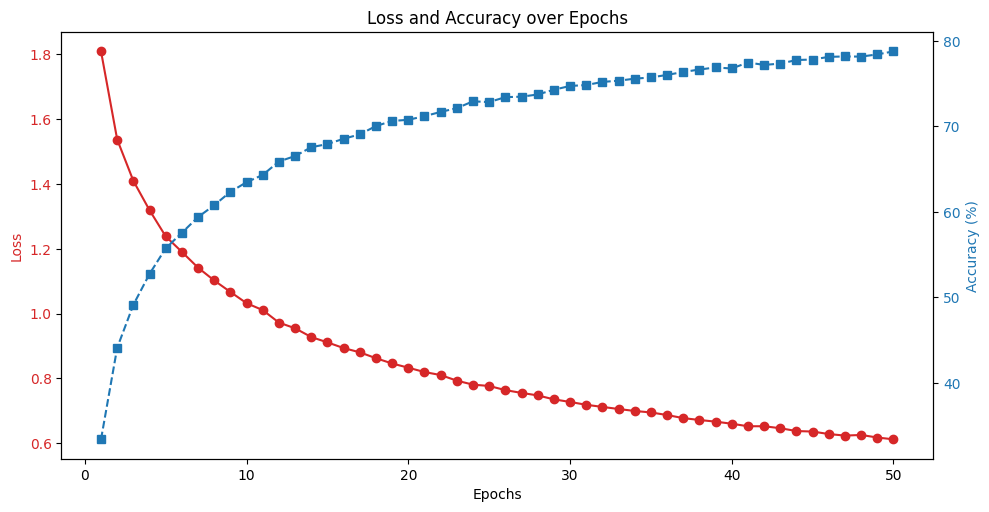

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Dữ liệu Loss và Accuracy
epochs = np.arange(1, 51)
# loss_values = [2.0081, 1.6934, 1.5902, 1.5317, 1.4945, 1.4551, 1.4370, 1.4125, 1.3917, 1.3744, 
#                1.3601, 1.3375, 1.3243, 1.3117, 1.3055, 1.2938, 1.2764, 1.2789, 1.2624, 1.2622, 
#                1.2505, 1.2430, 1.2328, 1.2301, 1.2265, 1.2240, 1.2151, 1.2158, 1.2121, 1.2008, 
#                1.1971, 1.1956, 1.1910, 1.1871, 1.1854, 1.1810, 1.1856, 1.1802, 1.1726, 1.1690, 
#                1.1690, 1.1742, 1.1624, 1.1624, 1.1578, 1.1605, 1.1572, 1.1496, 1.1483, 1.1572]

# accuracy_values = [26.27, 39.08, 42.98, 45.25, 46.47, 48.14, 48.78, 49.91, 50.56, 51.23, 
#                    51.77, 52.71, 52.99, 53.31, 53.97, 54.28, 54.92, 54.71, 55.23, 55.37, 
#                    56.07, 56.23, 56.51, 56.65, 56.74, 56.75, 57.22, 57.08, 57.45, 58.09, 
#                    57.93, 58.07, 58.13, 58.46, 58.14, 58.58, 58.53, 58.70, 58.78, 58.89, 
#                    58.93, 58.84, 59.17, 59.39, 59.25, 59.17, 59.40, 59.67, 59.46, 59.33]

loss_values = [1.8091, 1.5371, 1.4094, 1.3189, 1.2381, 1.1902, 1.1414, 1.1019, 1.0665, 1.0318,
               1.0105, 0.9719, 0.9544, 0.9273, 0.9109, 0.8933, 0.8802, 0.8620, 0.8457, 0.8327,
               0.8193, 0.8100, 0.7927, 0.7804, 0.7763, 0.7635, 0.7549, 0.7472, 0.7350, 0.7270,
               0.7182, 0.7117, 0.7052, 0.6991, 0.6946, 0.6866, 0.6771, 0.6713, 0.6662, 0.6597,
               0.6520, 0.6520, 0.6459, 0.6372, 0.6356, 0.6279, 0.6231, 0.6251, 0.6172, 0.6116]

accuracy_values = [33.40, 44.11, 49.14, 52.75, 55.75, 57.56, 59.40, 60.79, 62.35, 63.48,
                   64.33, 65.90, 66.54, 67.57, 67.94, 68.56, 69.07, 70.05, 70.64, 70.78,
                   71.20, 71.70, 72.14, 72.94, 72.85, 73.43, 73.48, 73.74, 74.29, 74.74,
                   74.84, 75.21, 75.35, 75.59, 75.73, 76.03, 76.37, 76.66, 76.90, 76.78,
                   77.48, 77.20, 77.35, 77.77, 77.83, 78.14, 78.19, 78.17, 78.43, 78.78]

# Vẽ đồ thị
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, loss_values, color=color, marker='o', label='Loss')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Accuracy (%)', color=color)
ax2.plot(epochs, accuracy_values, color=color, marker='s', linestyle='dashed', label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Loss and Accuracy over Epochs')
plt.show()


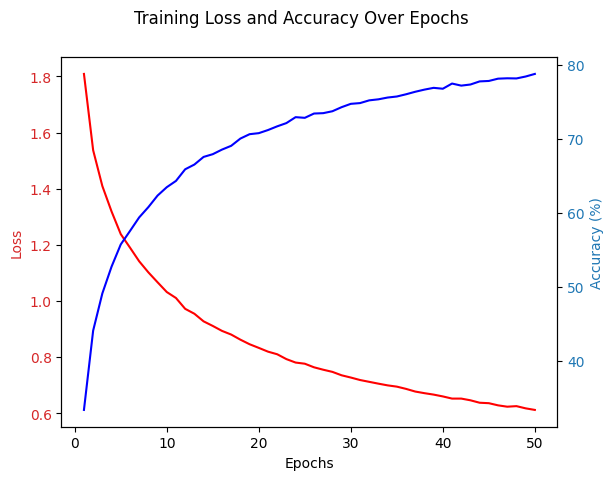

In [11]:
import matplotlib.pyplot as plt

# Dữ liệu từ output
epochs = list(range(1, 51))
loss_values = [1.8091, 1.5371, 1.4094, 1.3189, 1.2381, 1.1902, 1.1414, 1.1019, 1.0665, 1.0318,
               1.0105, 0.9719, 0.9544, 0.9273, 0.9109, 0.8933, 0.8802, 0.8620, 0.8457, 0.8327,
               0.8193, 0.8100, 0.7927, 0.7804, 0.7763, 0.7635, 0.7549, 0.7472, 0.7350, 0.7270,
               0.7182, 0.7117, 0.7052, 0.6991, 0.6946, 0.6866, 0.6771, 0.6713, 0.6662, 0.6597,
               0.6520, 0.6520, 0.6459, 0.6372, 0.6356, 0.6279, 0.6231, 0.6251, 0.6172, 0.6116]

accuracy_values = [33.40, 44.11, 49.14, 52.75, 55.75, 57.56, 59.40, 60.79, 62.35, 63.48,
                   64.33, 65.90, 66.54, 67.57, 67.94, 68.56, 69.07, 70.05, 70.64, 70.78,
                   71.20, 71.70, 72.14, 72.94, 72.85, 73.43, 73.48, 73.74, 74.29, 74.74,
                   74.84, 75.21, 75.35, 75.59, 75.73, 76.03, 76.37, 76.66, 76.90, 76.78,
                   77.48, 77.20, 77.35, 77.77, 77.83, 78.14, 78.19, 78.17, 78.43, 78.78]

# Vẽ đồ thị
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:red')
ax1.plot(epochs, loss_values, 'r-', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:blue')
ax2.plot(epochs, accuracy_values, 'b-', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.suptitle("Training Loss and Accuracy Over Epochs")
plt.show()
